In [5]:
#importing required libraries
import numpy as np
import tensorflow as tf
from keras.applications import vgg16
from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array
from IPython.display import Image as displayImage
from matplotlib.pyplot import imshow
from PIL import Image
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

In [6]:
%matplotlib inline
#height and width of the images
#you can set it to any dimensions
height = 512
width = 512

#loading base/content image
base_image = Image.open("ao.jpg")
#Image.fromarray(np.array(base_image)).show()

#setting height and width of the images and converting to appropriate tensors
base_image = base_image.resize((height, width))
base_image = np.asarray(base_image, dtype='float32')
base_image= np.expand_dims(base_image, axis=0)
print(base_image.shape)

#loading reference/style image
ref_image = Image.open("wave.jpg")
ref_image = ref_image.resize((height, width))
ref_image = np.asarray(ref_image, dtype='float32')
ref_image= np.expand_dims(ref_image, axis=0)

#converting the image tensors to Keras variables
base_image = K.variable(np.asarray(base_image))
ref_image = K.variable(np.asarray(ref_image))

#output image/art
comb_image = K.placeholder((1,512,512,3))

print (base_image)

(1, 512, 512, 3)
Tensor("Variable_4/read:0", shape=(1, 512, 512, 3), dtype=float32)


In [7]:
input_tensor = K.concatenate([base_image, ref_image, comb_image], axis=0)

In [8]:
#loading the VGG16 model with pretrained weights
#Internet required for first time
model = vgg16.VGG16(input_tensor=input_tensor, weights = 'imagenet', include_top=False)
print ("Model Downloaded")

Model Downloaded


In [9]:
# get the symbolic output of each "key" layer
layers = dict([(layer.name, layer.output) for layer in model.layers])

In [10]:
base_image_weight = 0.025
ref_image_weight = 5.0
total_variation_weight = 1.0

In [11]:
loss = K.variable(0.0)

In [12]:
def base_loss(base, combination):
    return K.sum(K.square(combination - base))

layer_features = layers['block2_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += base_image_weight * base_loss(base_image_features, combination_features)

In [13]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2,0,1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [14]:
def ref_loss(ref, combination):
    R = gram_matrix(ref)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return K.sum(K.square(R - C)) / (4.0 * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']

for layer_name in feature_layers:
    layer_features = layers[layer_name]
    ref_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    rl = ref_loss(ref_features, combination_features)
    loss += (ref_image_weight / len(feature_layers)) * rl

In [15]:
def total_variation_loss(x):
    a = K.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = K.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(comb_image)
print(loss)

Tensor("add_20:0", shape=(), dtype=float32)


In [90]:
grads = K.gradients(loss, comb_image)

outputs = [loss]
if type(grads) in {list, tuple}:
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([comb_image], outputs)


In [91]:
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [92]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 5.89765e+11
Iteration 0 completed in 354s
Start of iteration 1
Current loss value: 8.13598e+10
Iteration 1 completed in 350s
Start of iteration 2
Current loss value: 5.48024e+10
Iteration 2 completed in 341s
Start of iteration 3
Current loss value: 4.73424e+10
Iteration 3 completed in 337s
Start of iteration 4
Current loss value: 4.36386e+10
Iteration 4 completed in 343s
Start of iteration 5
Current loss value: 4.15524e+10
Iteration 5 completed in 341s
Start of iteration 6
Current loss value: 4.01948e+10
Iteration 6 completed in 343s
Start of iteration 7
Current loss value: 3.93453e+10
Iteration 7 completed in 335s
Start of iteration 8
Current loss value: 3.87497e+10
Iteration 8 completed in 339s
Start of iteration 9
Current loss value: 3.8266e+10
Iteration 9 completed in 340s


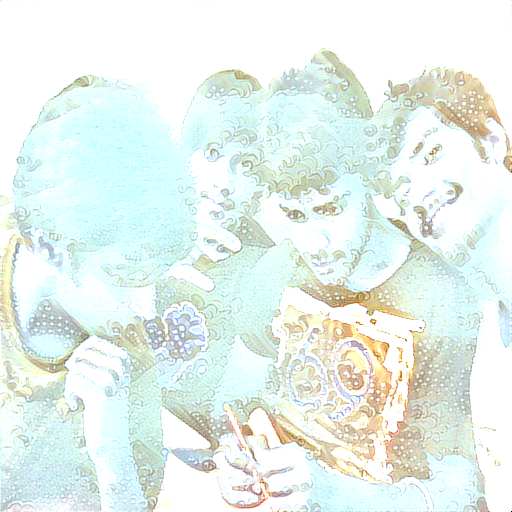

In [93]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)